In [2]:
import math
import torch
import pennylane as qml
import qw_map
import einops
import numpy
from sklearn import datasets
from typing import Literal
import tqdm
from pathlib import Path
from icecream import ic
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cpu")

In [4]:
class QDenseUndirected(torch.nn.Module):
    qdepth: int
    height: int
    width: int
    wires: int

    qnode: qml.QNode

    weights: torch.nn.Parameter

    def __init__(self, shape: tuple[int, int] | int, qdepth: int = 6) -> None:
        super().__init__()
        self.qdepth = qdepth

        if isinstance(shape, int):
            shape = (shape, shape)

        self.width, self.height = shape
        self.pixels = self.width * self.height
        self.wires = math.ceil(math.log2(self.width * self.height))

        weights = torch.randn((self.qdepth, self.wires, 3), requires_grad=True)
        self.weights = torch.nn.Parameter(weights * 0.4)

        qdev = qml.device("default.qubit", wires=self.wires)
        self.qnode = qml.QNode(
            func=self.circuit,
            device=qdev,
            interface="torch",
            diff_method="backprop",
        )

    def circuit(self, x: torch.Tensor):
        qml.AmplitudeEmbedding(
            features=x,
            wires=range(self.wires),
            normalize=True,
            pad_with=0.1,
        )
        qml.StronglyEntanglingLayers(
            weights=qw_map.tanh(self.weights),
            wires=range(self.wires),
        )
        return qml.probs(wires=range(self.wires))
    
    def apply_circuit(self, input: torch.Tensor) -> torch.Tensor:
        out = self.qnode(input)
        assert isinstance(out, torch.Tensor)

        # probs = probs[:, ::2] # Drop all probabilities for |xxxx1>
        out = out[:, : self.pixels]
        out = out * self.pixels
        out = torch.clamp(out, 0, 1)

        return out

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = einops.rearrange(x, "b 1 w h -> b (w h)")
        x = self.apply_circuit(x)
        x = einops.rearrange(x, "b (w h) -> b 1 w h", w=self.width, h=self.height)
        return x
    
    def __repr__(self) -> str:
        return f"QDenseUndirected(qdepth={self.qdepth}, wires={self.wires})"

    def save_name(self) -> str:
        return f"qdense_undirected_d{self.qdepth}_w{self.width}_h{self.height}"

In [5]:
def mnist_8x8(
    device: torch.device,
    n_classes: int = 10,
    ds_size: int = 100,
) -> tuple[torch.Tensor, torch.Tensor]:
    x_train_arr: numpy.ndarray
    y_train_arr: numpy.ndarray
    x_train_arr, y_train_arr = datasets.load_digits(n_class=n_classes, return_X_y=True)  # type: ignore
    
    x_train = torch.from_numpy(x_train_arr).to(device, dtype=torch.float32)
    x_train /= 16
    x_train = x_train.reshape(-1, 64)
    
    y_train = torch.from_numpy(y_train_arr).to(device, dtype=torch.float32)
    y_train /= y_train.max()
    
    x_train = x_train[:ds_size]
    y_train = y_train[:ds_size]
    
    return x_train, y_train

In [6]:
def add_normal_noise_multiple(
    data: torch.Tensor,
    tau: int,
    decay_mod: float = 1.0,
) -> torch.Tensor:
    """
    Distorting the data by sampling from one normal distribution with a fixed mean.
    Adding the noise with different weights to the tensor.
    """

    if data.dim() == 1:
        data = data.unsqueeze(0)

    batch, pixels = data.shape
    noise = torch.normal(
        mean=0.5,
        std=0.2,
        size=(batch, pixels),
        device=data.device,
        dtype=torch.float32,
    )

    data_expanded = einops.repeat(data, "batch pixels -> tau batch pixels", tau=tau)
    noise_expanded = einops.repeat(noise, "batch pixels -> tau batch pixels", tau=tau)

    noise_weighting = torch.linspace(0, 1, tau, device=data.device, dtype=torch.float32) ** decay_mod
    noise_weighting = noise_weighting / noise_weighting.max()  # normalize
    noise_weighting = einops.repeat(noise_weighting, "tau -> tau batch 1", batch=batch)

    noisy_data = (
        data_expanded * (1 - noise_weighting) + noise_expanded * noise_weighting
    )
    noisy_data = noisy_data.clamp(0, 1)
    noisy_data = einops.rearrange(noisy_data, "tau batch pixels -> (batch tau) pixels")

    return noisy_data

In [7]:
class Diffusion(torch.nn.Module):
    prediction_goal: Literal["data", "noise"]
    height: int
    width: int
    directed: bool
    on_states: bool

    net: torch.nn.Module
    loss: torch.nn.Module

    def __init__(
        self,
        net: torch.nn.Module,
        prediction_goal: Literal["data", "noise"],
        shape: tuple[int, int],
        loss: torch.nn.Module = torch.nn.MSELoss(reduction="none"),
        directed: bool = False,
        on_states: bool = False,
    ) -> None:
        super().__init__()

        self.prediction_goal = prediction_goal
        self.width, self.height = shape
        self.directed = directed
        self.on_states = on_states
        
        self.net = net
        self.loss = loss

        if self.on_states:
            self.loss = StateLoss()

    def forward(self, x: torch.Tensor, y: torch.Tensor, tau: int) -> torch.Tensor:
        whole_noisy = add_normal_noise_multiple(x, tau=tau + 1, decay_mod=3.0)
        whole_noisy = einops.rearrange(
            whole_noisy, "(batch tau) pixels -> batch tau pixels", tau=tau + 1
        )

        batches_noisy = whole_noisy[:, 1:, :]
        batches_noisy = einops.rearrange(
            batches_noisy,
            "batch tau (width height) -> (batch tau) 1 width height",
            width=self.width,
            height=self.height,
        )
        
        batches_clean = whole_noisy[:, :-1, :]
        batches_clean = einops.rearrange(
            batches_clean,
            "batch tau (width height) -> (batch tau) 1 width height",
            width=self.width,
            height=self.height,
        )

        output = self.net.forward(batches_noisy)
        assert isinstance(output, torch.Tensor)

        match self.prediction_goal:
            case "data":
                batches_reconstructed = output
                batch_loss = self.loss(batches_reconstructed, batches_clean)
                batch_loss_mean = batch_loss.mean()

            case "noise":
                predicted_noise = output
                predicted_noise = (predicted_noise - 0.5) * 0.1
                real_noise = batches_noisy - batches_clean
                batch_loss = self.loss(predicted_noise, real_noise)
                batch_loss_mean = batch_loss.mean()
        
        return batch_loss_mean

    def sample(
        self,
        n_iters: int,
        first_x: torch.Tensor | None = None,
        labels: torch.Tensor | None = None,
        show_progress: bool = False,
        only_last: bool = False,
        step: int = 1,
        noise_factor: float = 1.0,
    ) -> torch.Tensor:
        """ " Samples from the model for n_iters iterations."""
        if first_x is None:
            first_x = torch.rand((10, 1, self.width, self.height))
        if self.on_states:
            return self._sample_on_states(n_iters, first_x, only_last, labels=labels)

        if labels is None and self.directed:
            labels = torch.zeros((first_x.shape[0], 1))

        outp = [first_x]

        with torch.no_grad():
            x = first_x

            for i in range(n_iters):
                if self.directed:
                    predicted = self.net(x, labels)
                else:
                    predicted = self.net(x)

                if self.prediction_goal == "data":
                    x = predicted
                else:
                    predicted = (predicted - 0.5) * 0.1 * noise_factor
                    new_x = x - predicted
                    new_x = torch.clamp(new_x, 0, 1)
                    x = new_x

                if i % step == 0:
                    outp.append(x)

        if only_last:
            return outp[-1]
        else:
            outp = torch.stack(outp)
            outp = einops.rearrange(
                outp, "iters batch 1 height width -> (iters height) (batch width)"
            )

            return outp

    def _sample_on_states(
        self,
        n_iters: int,
        first_x: torch.Tensor,
        only_last: bool = True,
        labels: torch.Tensor | None = None,
    ) -> torch.Tensor:
        assert only_last, "can't sample intermediate states, set `only_last=True`"
        assert self.prediction_goal == "data", "can't sample noise"
        assert self.on_states, "use sample() instead"
        return self.net.sample(first_x, num_repeats=n_iters, labels=labels)  # type: ignore

    def get_variance_sample(self, **kwargs) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the sample and the variance over the iterations.
        """
        sample = self.sample(**kwargs).abs()
        sample = einops.rearrange(
            sample,
            "(iters height) (batch width) -> iters batch height width",
            height=self.height,
            width=self.width,
        )
        vars = sample.var(dim=1)
        sample = einops.rearrange(
            sample, "iters batch height width -> (iters height) (batch width)"
        )
        vars = einops.rearrange(vars, "iters height width -> (iters height) (width)")
        return sample, vars

    def save_name(self):
        return f"{self.net.save_name()}{'_noise' if self.prediction_goal == 'noise' else ''}"  # type: ignore
    

class StateLoss(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        assert input.is_complex(), "input must be complex"
        assert not target.is_complex(), "target must be real"
        return (input.real - target) ** 2 + input.imag**2

In [8]:
def train(
    diff: Diffusion,
    ds: torch.utils.data.DataLoader[tuple[torch.Tensor, torch.Tensor]],
    epochs: int,
    tau: int,
    lr: float,
    save_path: Path,
    device: torch.device,
) -> None:
    diff.train()

    pbar = tqdm.tqdm(total=epochs)
    opt = torch.optim.Adam(diff.parameters(), lr=lr)

    for _ in range(epochs):
        epoch_loss = 0.0

        for x, y in ds:
            opt.zero_grad()
            batch_loss = diff.forward(x, y, tau)
            epoch_loss += batch_loss

            batch_loss.backward()
            opt.step()

        pbar.set_postfix({"loss": epoch_loss.item()})
        pbar.update(1)

    pbar.close()
    sp = save_path / f"{diff.save_name()}.pt"

    if not sp.parent.exists():
        sp.parent.mkdir(parents=True)

    torch.save(diff.state_dict(), sp)

In [9]:
def test(diff: Diffusion, tau: int) -> None:
    diff.eval()

    first_x = torch.rand(15, 1, 8, 8) * 0.5 + 0.75
    output = diff.sample(first_x=first_x, n_iters=tau * 2, show_progress=True)
    
    plt.imshow(output.cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

In [10]:
x_train, y_train = mnist_8x8(device)

In [11]:
ds = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=10,
    shuffle=False,
)

In [12]:
net = QDenseUndirected(8, 55).to(device)
diff = Diffusion(net, prediction_goal="data", shape=(8, 8)).to(device)

In [15]:
train(diff, ds, epochs=1000, tau=10, lr=1e-4, save_path=Path("results"), device=device)

100%|██████████| 1000/1000 [48:04<00:00,  2.88s/it, loss=0.4] 


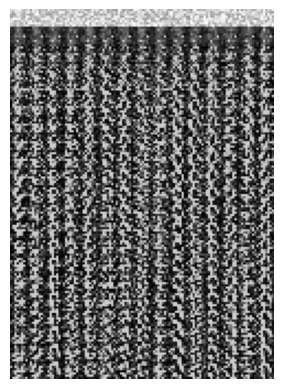

In [17]:
test(diff, tau=10)